# Titanic Kaggle Competition


In this notebook we're going to predict if a certain passenger of the titanic surived or not using machine learning.

This is a competition from kaggle, who provides the data to train, test and compare a submission

Data dictionary 

**PassengerId:**

**Pclass:** Ticket class, 1 = 1st, 2 = 2nd, 3 = 3rd

**Name:** Name of the passenger

**Sex:** Sex

**Age:** Age

**SibSp:** Number of siblings or spouses aboard the Titanic

**Parch:** Number of parents aboard the Titanic

**Ticket:** Ticket number

**Fare:** Passenger fare

**Cabin:** Cabin number

**Embarked:** Port of embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

**Surived:** Did the passanger survived, this is the label, 0 = No, 1 = Yes

In [42]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error

In [2]:
# Read the dataset
df = pd.read_csv('data/train.csv')

In [3]:
# Check the dataset
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## EDA - Exploratory Data Analysis 

Size and shape of the dataset

In [4]:
df.shape

(891, 12)

Check some aggregates of the dataset

In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Let's group the data by sex and print the counts and what kind of values Sex has 

In [6]:
df_group_sex = df.groupby('Sex').count()['PassengerId']
print(df_group_sex)

Sex
female    314
male      577
Name: PassengerId, dtype: int64


Visualize this aggregate

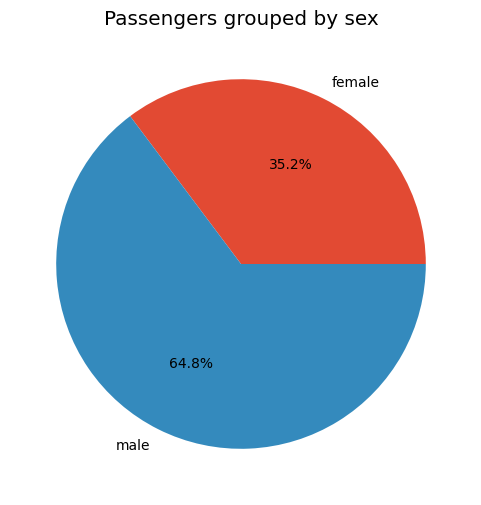

In [7]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.pie(df_group_sex, labels=df_group_sex.index, autopct='%.1f%%')
ax.set_title('Passengers grouped by sex')
plt.show()

Now by ticket class

In [8]:
df_group_class = df.groupby('Pclass').count()['PassengerId']
print(df_group_class)

Pclass
1    216
2    184
3    491
Name: PassengerId, dtype: int64


Corresponding pie chart

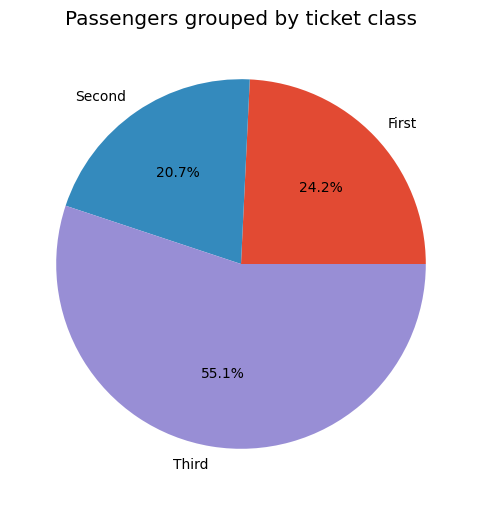

In [9]:
fig, ax = plt.subplots(1, 1, figsize= (6, 6))
ax.pie(df_group_class, labels=['First', 'Second', 'Third'], autopct='%.1f%%')
ax.set_title('Passengers grouped by ticket class')
plt.show()

## Data cleaning

Drop unique columns 

In [10]:
print(f'After dropping unique value columns: {df.shape}')
df = df.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1)
print(f'After dropping unique value columns: {df.shape}')

After dropping unique value columns: (891, 12)
After dropping unique value columns: (891, 8)


Check if there's any null or NaN (Not a Number) value in the dataset 

In [11]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

Drop any rows with at least one column with null values

In [12]:
print(f'Before dropping rows: {df.shape}')
df = df.dropna()
print(f'After dropping rows: {df.shape}')

Before dropping rows: (891, 8)
After dropping rows: (712, 8)


Check again, should be less

In [13]:
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

## Data transformation

Let's check again the ranges of the numerical data

In [14]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,0.404494,2.240169,29.642093,0.514045,0.432584,34.567251
std,0.491139,0.836854,14.492933,0.930692,0.854181,52.938648
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,20.000000,0.000000,0.000000,8.050000
50%,0.000000,2.000000,28.000000,0.000000,0.000000,15.645850
75%,1.000000,3.000000,38.000000,1.000000,1.000000,33.000000
max,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


Age and Fare have a big range of values we should normalize the data by removing the mean and dividing the value by the standard deviation

In [15]:
df['Age'].shape

(712,)

We need to passthrough a (n, n) array to the scaler not an (n,) array, so we're going to reshape the pandas series with `df['Age'].values.reshape((-1,1))`

In [16]:
scaler = StandardScaler()
df['Age'] = scaler.fit_transform(df['Age'].values.reshape(-1, 1))
df['Fare'] = scaler.fit_transform(df['Fare'].values.reshape(-1, 1))

Check the results, Age and Fare should be a value between 1 and -1 

In [17]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,-0.527669,1,0,-0.516380,S
1,1,1,female,0.577094,1,0,0.694046,C
2,1,3,female,-0.251478,0,0,-0.503620,S
3,1,1,female,0.369951,1,0,0.350326,S
4,0,3,male,0.369951,0,0,-0.501257,S


The 'Sex' and 'Embarked' columns are categorical features we should encode them in order to use them, first let's check the values

In [49]:
print(f'Sex Column: \n{df.Sex.value_counts()}\n')
print(f'Embarked Column: \n{df.Embarked.value_counts()}')

Sex Column: 
male      453
female    259
Name: Sex, dtype: int64

Embarked Column: 
S    554
C    130
Q     28
Name: Embarked, dtype: int64


Now let's encode the Sex and Embarked values as Binary and Label Enconded columns, in order to make the value male -> 0 and female -> 1, and the same with all embarked values

In [47]:
encoder = LabelEncoder()
df['Sex'] = encoder.fit_transform(df['Sex'])
df['Embarked'] = encoder.fit_transform(df['Embarked'])
print(f'Original Sex values: {encoder.classes_}\nEnconded Sex values: {encoder.transform(list(encoder.classes_))}')
print(f'Original Embarked values: {encoder.classes_}\nEnconded Embarked values: {encoder.transform(list(encoder.classes_))}')

Original Sex values: ['female' 'male']
Enconded Sex values: [0 1]


## Build the Model